<center><font size = "10"> Week 8 - Synapses<center>
<center><font size = "8">Tutorial 01: NMDA and AMPA model<center>

<font size='3'><font color='blue'> In this tutorial you will see how to:
    
<font size='3'><font color='blue'> - create a synapse model of AMPA and NMDA glutamate receptors decripbed in a MOD file.
    
<font size='3'><font color='blue'> - integrated into a simple neuron.
    
<font size='3'><font color='blue'> - make simulations to understand NMDA and AMPA receptors mechanisms

### Compile the MOD file

In [1]:
!nrnivmodl 

/home/in_silico/InSilicoClass/my_notebooks/week8
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  SimpleAMPA_NMDA.lo TsodyksMarkram_AMPA_NMDA.lo vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libn

### Load the modules and hoc files that will be used

In [2]:
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

### A neuron to host your synapse

<font size='3'>As the point of the tutorial is understand AMPA and NMDA receptors mechanism, we will create a single compartment soma neuron to host the synapse.

In [3]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

__nrnsec_0x275f320

In [4]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

<font size='3'>Create the synapse at the center of the soma compartment

In [5]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

### Define the stimulus:

<font size='3'> 8 spikes at 20Hz + 1 spike 500 ms later

In [6]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

### Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [7]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[4]

### AMPA conductance

<font size='3'>First, let's zero the NMDA conductance, and validate that the AMPA conductance is behaving as we expect.
    
<font size='3'>First we simulate, then we plot the voltage, and the conductance trajectories.

In [8]:
h.tstop = 1100.0 # ms
synapse.gmax_NMDA = 0.0
synapse.gmax_AMPA = 0.001 # uS
h.run()

0.0

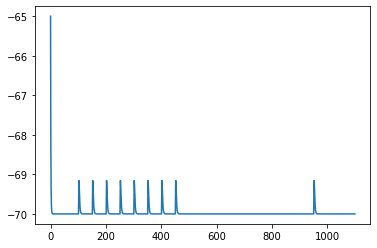

In [9]:
# This command gives us fancy interactive inline plots

plt.figure()
plt.plot(time, v_soma)

#### Conductance

<font size='3'>The dual exponential model for the conductance time course has a closed form for the response due to a single pulse.
Below we validate our .mod file implementation running in NEURON against this closed form solution. 

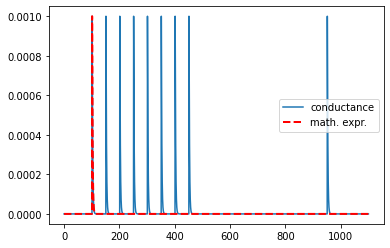

In [11]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = np.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*np.log(tau_d/tau_r)
    factor = -np.exp(-time_to_peak/tau_r)+np.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (np.exp(-t/tau_d) - np.exp(-t/tau_r))/factor
    dual_exp = np.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp

plt.figure()
plt.plot(time, g_syn, label = 'conductance')
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_AMPA, synapse.tau_d_AMPA, 
                                                  t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

### NMDA conductance

<font size='3'>Now, let's also validate the trajectory for the NMDA receptor alone.
    
<font size='3'>Here, we have to remove the Magnesium block by zeroing the Mg2+ concentration.

In [14]:
synapse.gmax_NMDA = 0.001 # uS
synapse.mg = 0.0 # mM
synapse.gmax_AMPA = 0 # uS
h.run()

0.0

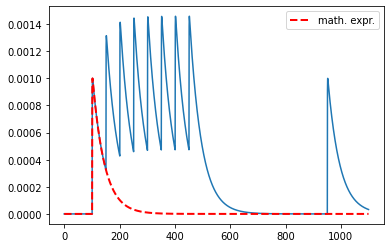

In [15]:
plt.figure()
#plot_timecourse(time, g_syn, newfigure=False, ylabel="Conductance (uS)", label="NEURON")
plt.plot(time, g_syn)
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

### AMPA and NMDA conductance

<font size='3'>Finally, let's configure the synapse to realistic biological ranges for the AMPA and NMDA conductances, and the Mg2+ concentration.  We'll record both the NMDA and AMPA conductances separately to visualize their contributions to the total conductance trajectory.

In [16]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
h.run()

0.0

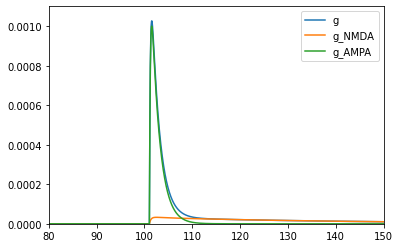

In [17]:
plt.figure()
plt.plot(time, g_syn, label='g')
plt.plot(time, g_NMDA, label= 'g_NMDA')
plt.plot(time, g_AMPA, label = 'g_AMPA')
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()